# K-Means Clustering

In [1]:
import kagglehub

import numpy as np
import pandas as pd
import datetime as dt

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

c:\Users\mia.jensen\Anaconda3\envs\Python_3_11_3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
path = kagglehub.dataset_download("yasserh/customer-segmentation-dataset")
filename = "Online Retail.xlsx"

In [3]:
df = pd.read_excel(path + "\\" + filename)
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [4]:
df_retail = df.copy() 

# remove nulls
df_retail = df_retail.dropna() 

# update data types
print(df_retail.dtypes)
df_retail["CustomerID"] = df_retail["CustomerID"].astype("str")

# calculated columns
df_retail['Amount'] = df_retail['Quantity'] * df_retail['UnitPrice']
df_retail['DateDiff'] = max(df_retail['InvoiceDate']) - df_retail['InvoiceDate']
df_retail.head()

InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID            float64
Country                object
dtype: object


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Amount,DateDiff
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,373 days 04:24:00
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,373 days 04:24:00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00


In [5]:
df_amounts = df_retail.groupby('CustomerID')['Amount'].sum().reset_index()
df_counts = df_retail.groupby('CustomerID')['InvoiceNo'].count().reset_index().rename(columns={"InvoiceNo": "InvoiceCount"})
df_recency = df_retail.groupby('CustomerID')['DateDiff'].min().reset_index().rename(columns={"DateDiff": "DaysLastInvoice"})
df_recency["DaysLastInvoice"] = df_recency["DaysLastInvoice"].dt.days

# merge all dataframes
df_summary = pd.merge(df_amounts, df_counts, on='CustomerID', how='inner')
df_summary = pd.merge(df_summary, df_recency, on='CustomerID', how='inner')
df_summary.head()

,CustomerID,Amount,InvoiceCount,DaysLastInvoice
0,12346.0,0.00,2,325
1,12347.0,4310.00,182,1
2,12348.0,1797.24,31,74
3,12349.0,1757.55,73,18
4,12350.0,334.40,17,309


In [6]:
df_reduced = df_summary[["Amount", "InvoiceCount", "DaysLastInvoice"]]
df_reduced

,Amount,InvoiceCount,DaysLastInvoice
0,0.00,2,325
1,4310.00,182,1
2,1797.24,31,74
3,1757.55,73,18
4,334.40,17,309
...,...,...,...
4367,180.60,10,277
4368,80.82,7,180
4369,176.60,13,7
4370,2094.88,756,3


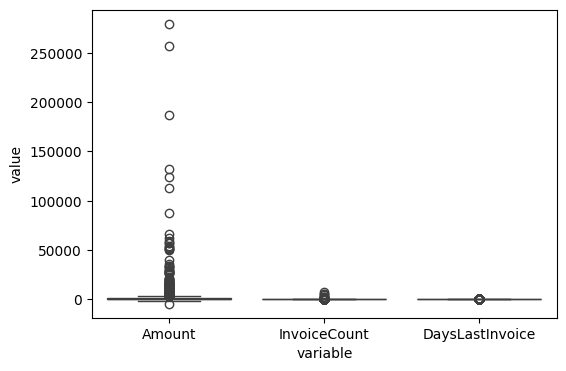

In [7]:
# check distributions
plt.figure(figsize=(6, 4))
boxplots = sns.boxplot(x="variable", y="value", data=pd.melt(df_reduced))
plt.show()

In [8]:
# handle outliers
def outlier_handling(df, col):
    Q1 = df[col].quantile(0.05)
    Q3 = df[col].quantile(0.95)
    IQR = Q3 - Q1
    df = df[(df[col] >= Q1 - 1.5 * IQR) & (df[col] <= Q3 + 1.5 * IQR)]
    return df

df_excl_outliers = outlier_handling(df_reduced, "Amount")
df_excl_outliers = outlier_handling(df_excl_outliers, "InvoiceCount")
df_excl_outliers = outlier_handling(df_excl_outliers, "DaysLastInvoice")

In [9]:
# standardise
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_excl_outliers)

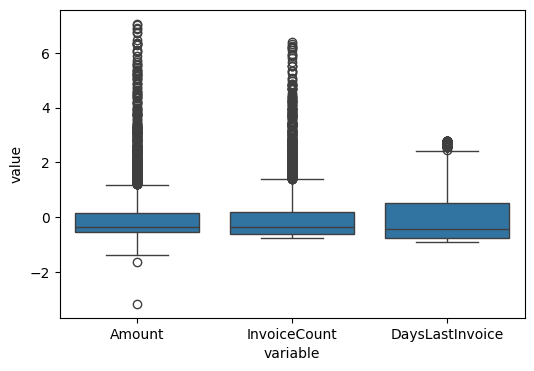

In [10]:
# check distributions again
plt.figure(figsize=(6, 4))
boxplots = sns.boxplot(x="variable", y="value", data=pd.melt(pd.DataFrame(df_scaled, columns=df_excl_outliers.columns)))
plt.show()

In [11]:
# build model
kmeans = KMeans(n_clusters=4, max_iter=50)
kmeans.fit(df_scaled)

KMeans(max_iter=50, n_clusters=4)

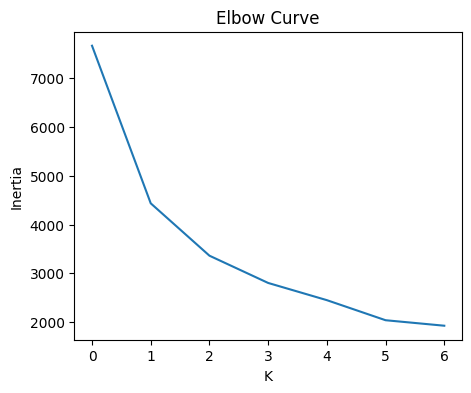

For n_clusters=2, the silhouette score is 0.539476924749887
For n_clusters=3, the silhouette score is 0.5084896296141937
For n_clusters=4, the silhouette score is 0.48184961525078546
For n_clusters=5, the silhouette score is 0.4616530636875477
For n_clusters=6, the silhouette score is 0.44824435025347525
For n_clusters=7, the silhouette score is 0.3808386803608656
For n_clusters=8, the silhouette score is 0.3389382271459986


In [12]:
# Choose most optimal number of clusters (k)

k_clusters = [2, 3, 4, 5, 6, 7, 8]

# Elbow Curve
ssd = []
for k in k_clusters:
    kmeans = KMeans(n_clusters=k, max_iter=50)
    kmeans.fit(df_scaled)
    ssd.append(kmeans.inertia_)

# plot the SSDs for each n_clusters
plt.figure(figsize=(5, 4))
plt.plot(ssd)
plt.title("Elbow Curve")
plt.xlabel("K")
plt.ylabel("Inertia")
plt.show()


# Silhouette Analysis

for num_clusters in k_clusters:

    # intialise kmeans
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(df_scaled)
    cluster_labels = kmeans.labels_

    # silhouette score
    silhouette_avg = silhouette_score(df_scaled, cluster_labels)
    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))

In [13]:
k = 3
kmeans = KMeans(n_clusters=k, max_iter=50)
kmeans.fit(df_scaled)
kmeans.labels_, len(kmeans.labels_)

(array([1, 2, 0, ..., 1, 0, 0], dtype=int32), 4293)

In [14]:
df_final = df_excl_outliers.copy()
df_final["ClusterID"] = kmeans.labels_
df_final.head()

,Amount,InvoiceCount,DaysLastInvoice,ClusterID
0,0.00,2,325,1
1,4310.00,182,1,2
2,1797.24,31,74,0
3,1757.55,73,18,0
4,334.40,17,309,1


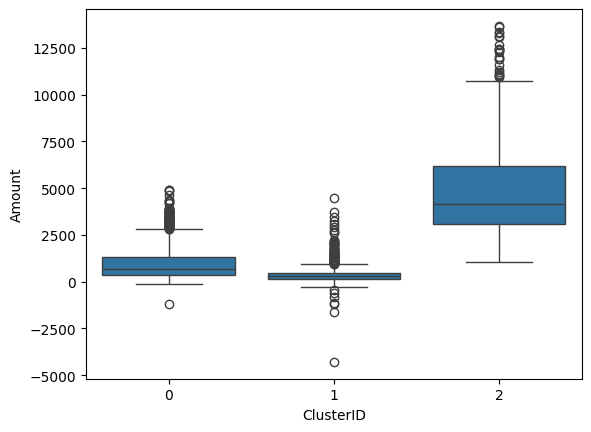

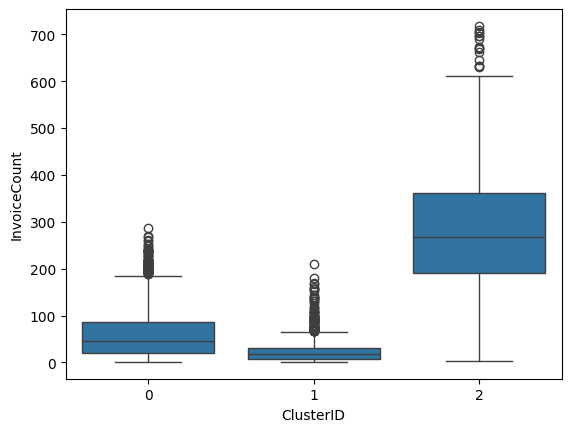

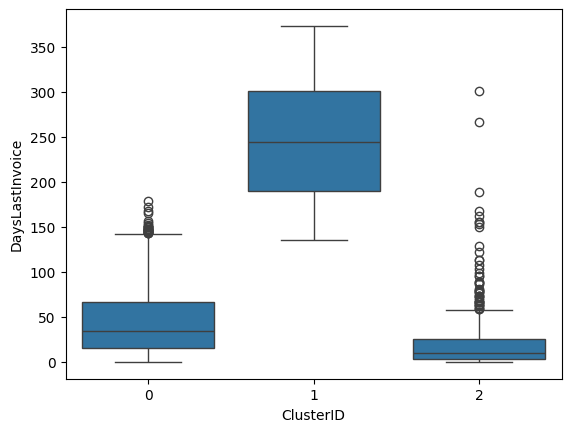

In [15]:
sns.boxplot(x='ClusterID', y='Amount', data=df_final)
plt.show()
sns.boxplot(x='ClusterID', y='InvoiceCount', data=df_final)
plt.show()
sns.boxplot(x='ClusterID', y='DaysLastInvoice', data=df_final)
plt.show()